In [103]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [104]:
from muzero.model import MuModel

In [105]:
env = gym.make("CartPole-v0")
m = MuModel(env.observation_space.shape, env.action_space.n)
env.reset(), env.observation_space.shape, env.action_space.n

(array([-0.00338204,  0.01748719,  0.01197838, -0.0069502 ]), (4,), 2)

In [106]:
from muzero.game import Game, ReplayBuffer
replay_buffer = ReplayBuffer(100, 128)

In [107]:
from muzero.mcts import get_mcts_policy, ucb_score

In [119]:
# init the game
game = Game(env)
policy, root = get_mcts_policy(m, game.observation)

In [120]:
root.visit_count, root.children[0].visit_count, root.children[1].visit_count

(10, 0, 10)

In [121]:
root.children[0].prior, root.children[1].prior

(0.08502477, 0.9149752)

In [122]:
def print_tree(x, hist=[]):
  print(x.value(), x, hist)
  for i,c in x.children.items():
    print_tree(c, hist+[i])
print_tree(root)

7.758757496166529 <muzero.mcts.Node object at 0x15f38ba50> []
0 <muzero.mcts.Node object at 0x15ea29350> [0]
7.219451503051272 <muzero.mcts.Node object at 0x15f38b950> [1]
0 <muzero.mcts.Node object at 0x15f38bc10> [1, 0]
6.7120348060490675 <muzero.mcts.Node object at 0x15f38b4d0> [1, 1]
0 <muzero.mcts.Node object at 0x15ea33750> [1, 1, 0]
6.26463576104633 <muzero.mcts.Node object at 0x15ea33650> [1, 1, 1]
0 <muzero.mcts.Node object at 0x15f363d90> [1, 1, 1, 0]
5.828935325550759 <muzero.mcts.Node object at 0x15f363b90> [1, 1, 1, 1]
0 <muzero.mcts.Node object at 0x15d9ec7d0> [1, 1, 1, 1, 0]
5.384684435605667 <muzero.mcts.Node object at 0x15d9ec110> [1, 1, 1, 1, 1]
0 <muzero.mcts.Node object at 0x15f363550> [1, 1, 1, 1, 1, 0]
4.90784337907046 <muzero.mcts.Node object at 0x15f37f450> [1, 1, 1, 1, 1, 1]
0 <muzero.mcts.Node object at 0x15f37fd50> [1, 1, 1, 1, 1, 1, 0]
4.406423605181277 <muzero.mcts.Node object at 0x15f37ff90> [1, 1, 1, 1, 1, 1, 1]
0 <muzero.mcts.Node object at 0x15f37ffd0> 

In [131]:
def play_game():
  import random
  game = Game(env)
  while not game.terminal():
    #policy, _ = get_mcts_policy(m, game.observation)
    policy = search(m, game.observation)
    game.act_with_policy(policy)
  return game

In [ ]:
from muzero.model import reformat_batch
for j in range(50):
  game = play_game()
  print(game.history)
  replay_buffer.save_game(game)
  for i in range(10):
    m.train_on_batch(replay_buffer.sample_batch(5))
  print(len(game.history), m.losses[-1][0])
  if len(game.history) == 200:
    break

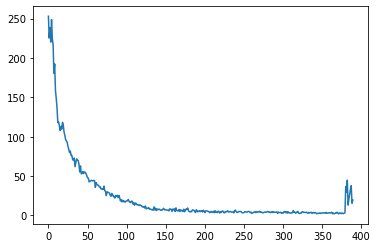

In [127]:
plot([x[0] for x in m.losses])

In [128]:
# can act?
state = env.reset()
for sn in range(2000):
  p_0 = search(m, state, debug=False)
  a_1 = np.random.choice(list(range(len(p_0))), p=p_0)
  #a_1 = np.argmax(p_0)
  #print(p_0, v_0, a_1)
  env.render()
  state,r,done,_ = env.step(a_1)
  if done:
    print("DONE", sn)
    break

DONE 199


In [23]:
def to_one_hot(x,n):
  ret = np.zeros([n])
  ret[x] = 1.0
  return ret

# enumerate the whole action space
K = 5
import itertools
aopts = list(itertools.product([0,1], repeat=K))
aoptss = np.array([[to_one_hot(x, env.action_space.n) for x in aa] for aa in aopts])
aoptss = aoptss.swapaxes(0,1)
aoptss = [aoptss[x] for x in range(K)]

# TODO: this is naive search, replace with MCTS
def search(m, o_0, debug=False):
  # concatenate the current state with every possible action
  o_0s = np.repeat(np.array(o_0)[None], len(aopts), axis=0)
  ret = m.mu.predict([o_0s]+aoptss)
  v_s = ret[-3]
  
  # group the value with the action rollout that caused it
  v = [(v_s[i][0], aopts[i]) for i in range(len(v_s))]
  if debug:
    print(sorted(v, reverse=True))
  
  av = [0] * env.action_space.n
  for vk, ak in v:
    av[ak[0]] += vk
    
  policy = np.exp(av)/sum(np.exp(av))
  return policy